# Image Denoiser

In this project, an Autoencoder-based deep learning model is developed to reconstruct and denoise air temperature-related visual data, simulating noisy sensor imagery. All input images are preprocessed and resized to 100×100 pixels to fit the network architecture, and Gaussian noise is added to mimic corrupted input data.

Two autoencoder models are would be compared:
1. A baseline Auto Encoder model with an architecture as follow:

| Layer         | Type         | Output Shape   | Kernel Size | Activation |
| ------------- | ------------ | -------------- | ----------- | ---------- |
| Input Layer   | Input        | (100, 100, 3)  | -           | -          |
| Conv2D_0      | Conv2D       | (100, 100, 32) | 3×3         | ReLU       |
| MaxPool2D_0   | MaxPooling2D | (50, 50, 32)   | 2×2         | -          |
| Conv2D_1      | Conv2D       | (50, 50, 64)   | 3×3         | ReLU       |
| MaxPool2D_1   | MaxPooling2D | (25, 25, 64)   | 2×2         | -          |
| Conv2D_2      | Conv2D       | (25, 25, 64)   | 3×3         | ReLU       |
| UpSample2D_0  | UpSampling2D | (50, 50, 64)   | -           | -          |
| Conv2D_3      | Conv2D       | (50, 50, 32)   | 3×3         | ReLU       |
| UpSample2D_1  | UpSampling2D | (100, 100, 32) | -           | -          |
| Conv2D_4      | Conv2D       | (100, 100, 3)  | 3×3         | Sigmoid    |


The optimizer for the baseline Auto Encoder model is Adam with a loss function of MSE.

2. A proposed Auto Encoder model optimized using Optuna for hyperparameter tuning.

All images were resized to 100x100 to match model input requirements. Gaussian noise was added to simulate corrupted data, useful for training the autoencoder to denoise images.


## Import Libraries

In [1]:

# Common python libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pynvml
import os
import glob
from tqdm import tqdm
import time
from IPython.display import clear_output
import joblib
import shutil
import random
import math
import copy
from PIL import Image
from PIL import ImageFile

# Deep Learning Libraries
import torch
import torch.nn as nn
from torch import optim
from torchvision import transforms
from torchvision.transforms import v2
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# Hyper Parameter Tuning
import optuna
from optuna.exceptions import TrialPruned
from optuna.trial import TrialState

# Data preprocessing
from sklearn.model_selection import train_test_split

# Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix

## GPU Check

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("Pytorch is using the GPU")

    pynvml.nvmlInit()

    num_gpus = pynvml.nvmlDeviceGetCount()

    for i in range(num_gpus):
        handle = pynvml.nvmlDeviceGetHandleByIndex(i)
        gpu_name = pynvml.nvmlDeviceGetName(handle)
        print("GPU Name:", gpu_name)

    pynvml.nvmlShutdown()
else:
    print("Pytorch is not using the GPU")

Pytorch is not using the GPU


In [3]:
print("Num GPUs Available: ", torch.cuda.device_count())

Num GPUs Available:  0


## Importing the Data

In [4]:
def img_to_df(img_path: str):
    """
    Convert image paths to DataFrame. for easier data preprocessing.
    
    Args:
        img_path (str): Path to the folder containing the image.
    
    Returns:
        pd.DataFrame: DataFrame containing image path, label, width, height, and channel_info.
    """
    #checks
    if not isinstance(img_path, str):
        raise TypeError("img_path must be a string.")
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"The path {img_path} does not exist.")
    if not os.path.isdir(img_path):
        raise NotADirectoryError(f"The path {img_path} is not a directory.")
    
    # Get the list of all image files in the directory
    glob_path = os.path.join(img_path, "**", "*.jpg")
    print(f"glob_path: {glob_path}")
    
    image_path = glob.glob(glob_path, recursive=True) #recursive=True is to allow for subdirectories to be searched
    print(f"image_path: {image_path}")
    
    # Get the width, height, and channel information of the images
    width = []
    height = []
    channel_info = []
    avg_red = []
    avg_green = []
    avg_blue = []
    
    for path in tqdm(image_path, desc="Processing images", unit="image"):
        img = cv2.imread(path)
        if img is None:
            print(f"Skipping corrupted image: {path}")
            continue

        h, w, c = img.shape
        average = img.mean(axis=0).mean(axis=0)
        
        # Append to the list
        height.append(h)
        width.append(w)
        channel_info.append(c)
        avg_blue.append(average[0])
        avg_green.append(average[1])
        avg_red.append(average[2])
        
        
    #combine into one dataframe
    df = pd.DataFrame({
        "image_path": image_path,
        "width": width,
        "height": height,
        "channel_info": channel_info,
        "img_avg_red": avg_red,
        "img_avg_green": avg_green,
        "img_avg_blue": avg_blue
    })
    
    return df

### Caching Function to Load the Data Faster

In [5]:
def save_cache(data, filename):
    """This is a function to save the data to a file using joblib

    Args:
        data (_type_): data to be saved
        filename (_type_): the name of the file to save the data to
    """
    with open(filename, 'wb') as f:
        joblib.dump(data, f)
    print(f"Data saved to {filename}")

def load_cache(filename):
    """This is a function to load the data to a file using joblib

    Args:
        data (_type_): data to be saved
        filename (_type_): the name of the file to load the data to
    """
    with open(filename, 'rb') as f:
        return joblib.load(f)
    print(f"Data loaded from {filename}")

In [6]:
data_path = "./dataset/"
write_path = "./Cache/"

if not os.path.exists(write_path):
            os.makedirs(write_path)

csv_path = os.path.join(write_path, "path_dataset.csv")

# We will cache the data so that it will load faster
if os.path.exists(csv_path):
    print("Loading cached dataset...")
    img_df = pd.read_csv(csv_path)
    print("Cached dataset loaded")
else:
    print("Creating and caching dataset...")
    img_df = img_to_df(data_path)
    img_df.to_csv(csv_path, index=False)

Loading cached dataset...
Cached dataset loaded


In [7]:
img_df.head()

,image_path,width,height,channel_info,img_avg_red,img_avg_green,img_avg_blue
0,./dataset/kirmizi 680.jpg,600,600,3,26.872642,25.172472,24.834806
1,./dataset/kirmizi 986.jpg,600,600,3,55.434728,53.172314,50.263817
2,./dataset/kirmizi 1000.jpg,600,600,3,47.494778,45.017839,39.948303
3,./dataset/kirmizi 1001.jpg,600,600,3,51.244636,49.768544,47.024422
4,./dataset/kirmizi 1002.jpg,600,600,3,35.940481,33.959889,30.202314


In [8]:
#setting the colors generator
def fill_color_generator():
    """This generates a color

    Returns:
        color: An R,G,B value with a range of 0 to 1
    """
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    return (r/255, g/255, b/255)

In [9]:
#function for plotting numerical data distribution
def numeric_dist_plot(data: pd.DataFrame):
    """This function creates a plot of the distribution of the numerical data.

    Args:
        data (pd.DataFrame): Numeric pandas dataframe

    Raises:
        TypeError: The following columns are not numeric: {non_numeric_cols}
        This is due to some of the columns are not numeric.

    Returns:
        Displays a plot of
    """
    # Checks
    ## Check if all columns are numeric
    non_numeric_cols = [col for col in data.columns if not pd.api.types.is_numeric_dtype(data[col])]
    if non_numeric_cols:
        raise TypeError(f"The following columns are not numeric: {non_numeric_cols}")

    # Plotting the numerical data
    #titles for plots/figures
    fig_titles = []

    for colName in data.columns:
        fig_titles.append(f"Boxplot Of {colName}")
        fig_titles.append(f"Histogram Of {colName}")

    fill_color_dict = {}
    for colName in data.columns:
        fill_color_dict[colName] = fill_color_generator()

    # make subplot for each column name
    num_rows = len(data.columns)
    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, num_rows * 3))

    # Flatten axes for easier indexing when there's more than 1 row
    axes = axes if num_rows > 1 else [axes]

    for i, column in enumerate(data.columns):
        color = fill_color_dict[column]

        # Boxplot
        axes[i][0].boxplot(data[column].dropna(), vert=False, patch_artist=True,
                        boxprops=dict(facecolor=color, color=color),
                        medianprops=dict(color="black"))
        axes[i][0].set_title(f"Boxplot of {column}")
        axes[i][0].set_xlabel(column)

        # Histogram
        axes[i][1].hist(data[column].dropna(), bins=20, color=color, alpha=0.7, edgecolor='black')
        axes[i][1].set_title(f"Histogram of {column}")
        axes[i][1].set_xlabel(column)

    # Overall layout
    fig.suptitle("Boxplot and Distribution Visualization for Each Numeric Column", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to fit title
    return plt

In [10]:
numeric_data = img_df.select_dtypes(include=[np.number])
numeric_data.columns

Index(['width', 'height', 'channel_info', 'img_avg_red', 'img_avg_green',
       'img_avg_blue'],
      dtype='object')

<module 'matplotlib.pyplot' from '/home/andrew/miniconda3/envs/torch-env/lib/python3.11/site-packages/matplotlib/pyplot.py'>

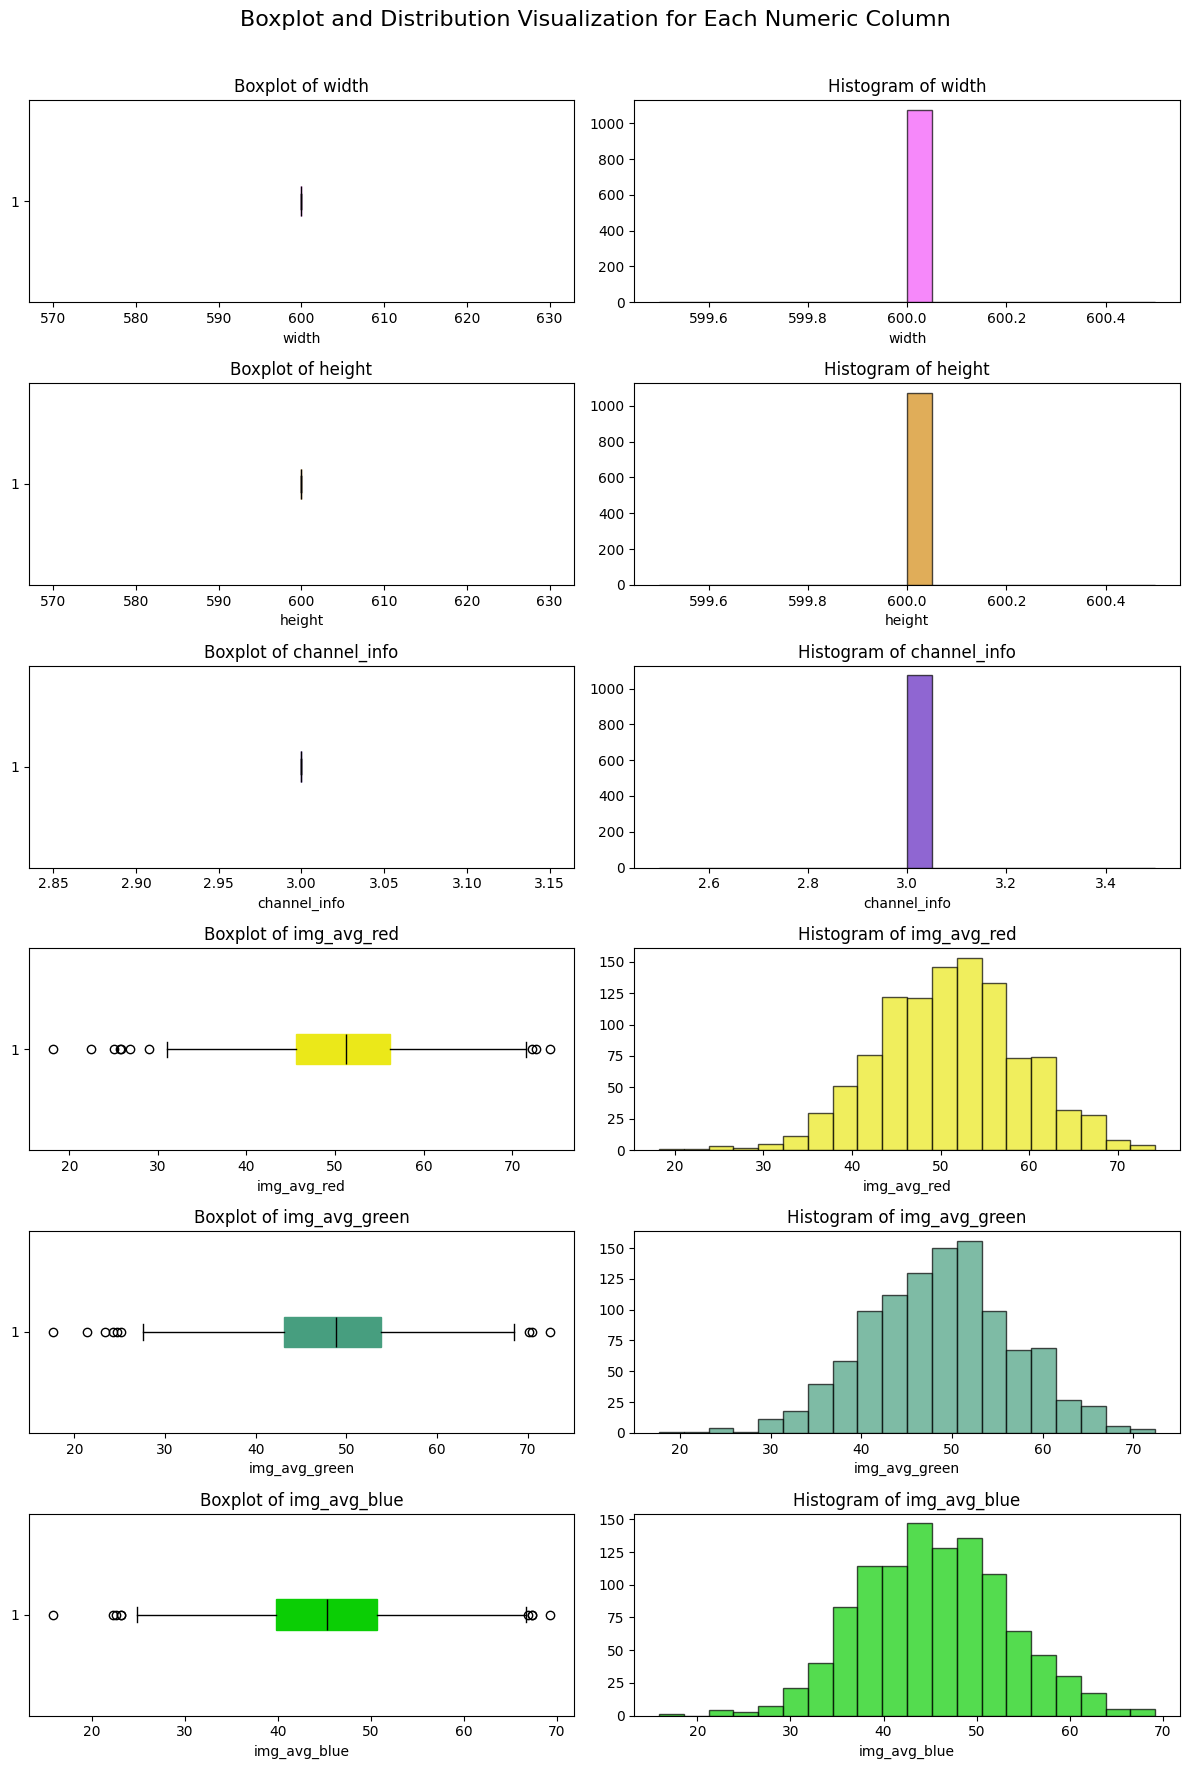

In [11]:
numeric_dist_plot(numeric_data)

## Preprocesing the images

In [12]:
def create_datasets(df: pd.DataFrame, test_size: float = 0.1, val_size: float = 0.1):
    """
    Create train, validation, and test datasets.

    Args:
        df (pd.DataFrame): DataFrame containing image paths and labels.
        test_size (float): Proportion of the dataset to include in the test split.
        val_size (float): Proportion of the dataset to include in the validation split.
    """
    # Splitting the data into train and temp (which will be further split into validation and test)
    train_df, temp_df = train_test_split(df, test_size=(test_size + val_size), random_state=42)

    # Splitting train into validation and test sets
    val_df, test_df = train_test_split(temp_df, test_size=test_size / (test_size + val_size), random_state=42)

    # Make empty directories for the data
    data_path = "./input_data/"

    ## path to destination folders
    train_folder = os.path.join(data_path, 'train')
    val_folder = os.path.join(data_path, 'validation')
    test_folder = os.path.join(data_path, 'test')

    if os.path.exists(train_folder) and os.path.exists(val_folder) and os.path.exists(test_folder):
        print("Cached dataset directories found, skipping copying.")
        # Optionally: load the split info from saved CSVs
        train_df = pd.read_csv(os.path.join(data_path, "train_split.csv"))
        val_df = pd.read_csv(os.path.join(data_path, "val_split.csv"))
        test_df = pd.read_csv(os.path.join(data_path, "test_split.csv"))
        return train_df, val_df, test_df

    ## Create the directories
    for folder_path in [train_folder, val_folder, test_folder]:
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

    # Copy Images
    ## Train Images
    for img_path in tqdm(train_df['image_path'], desc="Copying Train Images"): #tqdm is used to show the progress bar
        filename = os.path.basename(img_path)
        os.makedirs(train_folder, exist_ok=True)
        shutil.copy(img_path, os.path.join(train_folder, filename))

    ## Test Images
    for img_path in tqdm(test_df['image_path'], desc="Copying Test Images"): #tqdm is used to show the progress bar
        filename = os.path.basename(img_path)
        os.makedirs(test_folder, exist_ok=True)
        shutil.copy(img_path, os.path.join(test_folder, filename))

    ## Validation Images
    for img_path in tqdm(val_df['image_path'], desc="Copying Validation Images"): #tqdm is used to show the progress bar
        filename = os.path.basename(img_path)
        os.makedirs(val_folder, exist_ok=True)
        shutil.copy(img_path, os.path.join(val_folder, filename))

    # Save CSVs for caching next time
    train_df.to_csv(os.path.join(data_path, "train_split.csv"), index=False)
    val_df.to_csv(os.path.join(data_path, "val_split.csv"), index=False)
    test_df.to_csv(os.path.join(data_path, "test_split.csv"), index=False)

    return train_df, val_df, test_df

In [13]:
train_df, val_df, test_df = create_datasets(img_df)

Cached dataset directories found, skipping copying.


### Add noise to the image

In [14]:
class NoisyDataset(Dataset):
    def __init__(self, img_path, transform=None):
        self.img_path = img_path
        
        self.transform = v2.Compose([
            v2.Resize((100,100)),
            v2.ToImage(), # Convert to tensor
            v2.ToDtype(torch.float32, scale=True), #Scale to [0, 1]
            v2.GaussianNoise(mean=0.0, sigma=0.1, clip=True) # Add Gaussian noise
        ])
        
        self.clean_transform = v2.Compose([
            v2.Resize((100, 100)),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True)
        ])
        
    def __len__(self): #tells PyTorch how many samples the dataset has. To know how many batches to create, Avoid indexing errors, randomly shuffle or split data
        return len(self.img_path)
    
    def __getitem__(self, idx):
        img = Image.open(self.img_path[idx]).convert("RGB")
        noise_img = self.transform(img)
        clean_img = self.clean_transform(img)
        return noise_img, clean_img

## Making the Model

### Data Loader

In [15]:
train_dataset = NoisyDataset(train_df['image_path'].values, transform=None)
val_dataset = NoisyDataset(val_df['image_path'].values, transform=None)
test_dataset = NoisyDataset(test_df['image_path'].values, transform=None)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Baseline Model

In [16]:
baseline_model_layers = [
    #Conv2D_0
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    
    #MaxPool2d_0
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    #Conv2D_1
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    
    #MaxPool2d_1
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.ReLU(),
    
    #Conv2D_2
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    
    #UpSample2D_0
    nn.Upsample(scale_factor=2, mode='nearest'),
    
    #Conv2D_3
    nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    
    #UpSample2D_1
    nn.Upsample(scale_factor=2, mode='nearest'),
    
    #Conv2D_4
    nn.Conv2d(in_channels=32, out_channels=3, kernel_size=3, stride=1, padding=1),
    nn.Sigmoid()
]

baseline_model = nn.Sequential(*baseline_model_layers)

#### Train the model

In [17]:
baseline_model = baseline_model.to(device)

loss_function = nn.MSELoss()
optimizer = optim.Adam(baseline_model.parameters(), lr=0.001)

In [18]:
# Training loop
num_epochs = 20
train_loss = []
val_loss = []

for epoch in tqdm(range(num_epochs)):
    baseline_model.train()
    running_train_loss = 0

    for noisy_imgs, clean_imgs in train_loader:
        noisy_imgs = noisy_imgs.to(device)
        clean_imgs = clean_imgs.to(device)

        optimizer.zero_grad()
        outputs = baseline_model(noisy_imgs)
        loss = loss_function(outputs, clean_imgs)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
    
    avg_train_loss = running_train_loss/len(train_loader)
    train_loss.append(avg_train_loss)
    
    running_val_loss = 0
    for noisy_imgs, clean_imgs in val_loader:
        noisy_imgs = noisy_imgs.to(device)
        clean_imgs = clean_imgs.to(device)

        optimizer.zero_grad()
        outputs = baseline_model(noisy_imgs)
        loss = loss_function(outputs, clean_imgs)
        loss.backward()
        optimizer.step()

        running_val_loss += loss.item()
    
    avg_val_loss = running_val_loss/len(val_loader)
    val_loss.append(avg_val_loss)
    
    tqdm.write(f"Epoch [{epoch+1}/{num_epochs}]\nTrain_Loss: {avg_train_loss:.4f}\nVal_Loss: {avg_val_loss:.4f}")
    time.sleep(3)
    clear_output(wait=True)


100%|██████████| 20/20 [03:17<00:00,  9.90s/it]


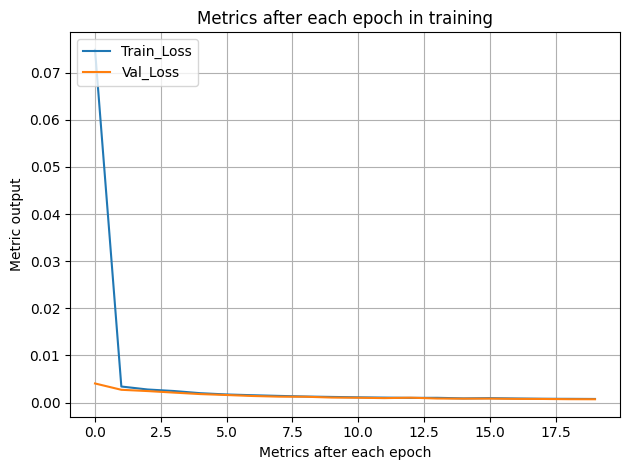

In [21]:
metrics = pd.DataFrame({
    "Train_Loss": train_loss,
    "Val_Loss" : val_loss
})

# Plot each feature
for col in metrics.columns:
    plt.plot(metrics[col], label=col, linewidth=1.5)

plt.xlabel("Metrics after each epoch")
plt.ylabel("Metric output")
plt.title("Metrics after each epoch in training")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()